In [3]:
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import IPython.display as ipd
import wget
import seaborn as sns
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.nn import TransformerConv
import polars as pl
import IPython.display as ipd
import soundfile as sf
from tqdm import tqdm

In [7]:
dir_path = "/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset"
dataset_path = os.path.join(dir_path, "fma_small")
metadata_path = os.path.join(dir_path, "fma_metadata")

tracks = pd.read_csv(os.path.join(metadata_path, "tracks.csv"), index_col=0, header=[0, 1])
genres = pd.read_csv(os.path.join(metadata_path, "genres.csv"), index_col=0, header=[0, 1])
features = pd.read_csv(os.path.join(metadata_path, "features.csv"), index_col=0, header=[0, 1])
echonest = pd.read_csv(os.path.join(metadata_path, "echonest.csv"), index_col=0, header=[0, 1])

# print the shape of the dataframes
print(f'tracks shape = {tracks.shape}')
print(f'genres shape = {genres.shape}')
print(f'features shape = {features.shape}')
print(f'echonest shape = {echonest.shape}')

trackid_list = tracks.index.tolist()
all_dfs_name = {}
for col in tracks.columns:
    df_name = col[0]
    df_col_name = col[1]
    if df_name not in all_dfs_name:
        all_dfs_name[df_name] = {}
    all_dfs_name[df_name][df_col_name] = tracks[col].values

print(all_dfs_name.keys())

for k, v in all_dfs_name.items():
    df_name = f'{k}_df'
    globals()[df_name] = pd.DataFrame(v)

print(album_df.columns)
print(artist_df.columns)
print(set_df.columns)
print(track_df.columns)

intermediate_df = track_df[['title', 'duration', 'genre_top']]
intermediate_df['track_id'] = trackid_list
intermediate_df = intermediate_df.dropna()
print(intermediate_df.shape)
intermediate_df.info()

/tmp/ipykernel_381699/3124744884.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(os.path.join(metadata_path, "features.csv"), index_col=0, header=[0, 1])


tracks shape = (106574, 52)
genres shape = (162, 4)
features shape = (106576, 518)
echonest shape = (13131, 249)
dict_keys(['album', 'artist', 'set', 'track'])
Index(['comments', 'date_created', 'date_released', 'engineer', 'favorites',
       'id', 'information', 'listens', 'producer', 'tags', 'title', 'tracks',
       'type'],
      dtype='object')
Index(['active_year_begin', 'active_year_end', 'associated_labels', 'bio',
       'comments', 'date_created', 'favorites', 'id', 'latitude', 'location',
       'longitude', 'members', 'name', 'related_projects', 'tags', 'website',
       'wikipedia_page'],
      dtype='object')
Index(['split', 'subset'], dtype='object')
Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')
(49597, 4)
<class 'pandas

/tmp/ipykernel_381699/3124744884.py:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  echonest = pd.read_csv(os.path.join(metadata_path, "echonest.csv"), index_col=0, header=[0, 1])
/tmp/ipykernel_381699/3124744884.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_df['track_id'] = trackid_list


In [9]:
# os.makedirs(os.path.join(dir_path, 'fma_small_songs'), exist_ok=True)
# song_files = glob.glob(os.path.join(dataset_path, '**/*.mp3'), recursive=True)
# for song_file in song_files:
#     os.rename(song_file, os.path.join(dir_path, 'fma_small_songs', os.path.basename(song_file)))

# folders = glob.glob(os.path.join(dataset_path, '**/'), recursive=True)
# print(folders)
# for folder in folders[1:]:
#     os.rmdir(folder)

In [14]:
# new_dir_path = os.path.join(dir_path, 'fma_small_songs')
# intermediate_df['track_id'] = intermediate_df['track_id'].apply(lambda x: str(x).zfill(6))
# song_files_paths = glob.glob(os.path.join(new_dir_path, '**/*.mp3'), recursive=True)
# print(len(song_files_paths))

# for f in song_files_paths:
#     track_id = os.path.basename(f).split('.')[0]
#     if track_id in intermediate_df['track_id'].values:
#         intermediate_df.loc[intermediate_df['track_id'] == track_id, 'file_path'] = f
# intermediate_df.dropna(inplace=True)
# print(intermediate_df.shape)
# new_dir_path_5s = os.path.join(dir_path, 'fma_small_5s')
# os.makedirs(new_dir_path_5s, exist_ok=True)


In [17]:
# for i in song_files_paths:
#     try:
#         x, fs = librosa.load(i)
#         duration = len(x)
#         greater_than_5s = fs * 5
#         if len(x) > greater_than_5s:
#             start = np.random.randint(0, len(x) - greater_than_5s)
#             x_5s = x[start:start + greater_than_5s]
#             new_fn = os.path.join(new_dir_path_5s, os.path.basename(i))
#             sf.write(new_fn, x_5s, fs)
#     except Exception as e:
#         print(i, e)
# five_s_song_files_paths = glob.glob(os.path.join(new_dir_path_5s, '**/*.mp3'), recursive=True)
# print(len(five_s_song_files_paths))
# intermediate_df['file_path_5s'] = intermediate_df['file_path'].apply(lambda x: x.replace('fma_small_songs', 'fma_small_5s'))
# print(intermediate_df['file_path_5s'].shape)


In [11]:
# check what tracks are missing from the 5s dataset and delete it from the dataframe as well
# missing_tracks = []
# for i in intermediate_df['file_path_5s']:
#     if i not in five_s_song_files_paths:
#         missing_tracks.append(i)
# print(missing_tracks)
# intermediate_df = intermediate_df[~intermediate_df['file_path_5s'].isin(missing_tracks)]
# print(intermediate_df.shape)
# intermediate_df.to_csv('intermediate_df.csv', index=False)
# intermediate_df.head()


In [12]:
# def compute_mff_for_dataset(df, emb_dim):
#     mfccs = []
#     file_paths = df['file_path_5s'].values
#     for f in tqdm(file_paths):
#         y, sr = librosa.load(f, sr=None)
#         mfcc_unnorm = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=emb_dim)
#         mfcc_mean = np.mean(mfcc_unnorm, axis=1)
#         mfccs.append(mfcc_mean)
#     mfcc_array = np.array(mfccs)
#     return mfcc_array

# mfcc = compute_mff_for_dataset(intermediate_df, 100)
# print(mfcc.shape)
# print("Feature extraction finished")

# np.save("mfcc_embeddings_fma_5s.npy", mfcc)

In [13]:
# G = nx.Graph()
# G.add_nodes_from(intermediate_df["track_id"])
# pos = nx.circular_layout(G)

# for i, row1 in tqdm(intermediate_df.iterrows()):
#     for j, row2 in intermediate_df.iterrows():
#         if row1["track_id"] != row2["track_id"] and row1["genre_top"] == row2["genre_top"]:
#             G.add_edge(row1["track_id"], row2["track_id"])

# nx.write_gml(G, "graph.gml")
# nx.write_pajek(G, "graph.net")
# nx.write_edgelist(G, "graph.edgelist")
# nx.write_adjlist(G, "graph.adjlist")

In [14]:
# how to load various format types
# G = nx.read_gml("graph.gml")
# G = nx.read_pajek("graph.net")
# G = nx.read_edgelist("graph.edgelist")
# G = nx.read_adjlist("graph.adjlist")

In [25]:
G = nx.read_gml("graph.gml")

In [4]:
intermediate_df = pd.read_csv('intermediate_df.csv')
labels = LabelEncoder().fit_transform(intermediate_df["genre_top"])
labels_tensor = torch.tensor(labels, dtype=torch.long)

mfcc_embeddings = np.load('mfcc_embeddings_fma_5s.npy')
sage_embeddings = np.load('mfcc_sage_embeddings_fma_5s.npy')
gcn_embeddings = np.load('mfcc_gcn_embeddings_fma_5s.npy')

unique_genres = sorted(list(set(intermediate_df["genre_top"])))
n_genres = len(unique_genres)
genre_to_id = {unique_genres[_]: _ for _ in range(n_genres)}
id_to_genre = {_: unique_genres[_] for _ in range(n_genres)}
print(id_to_genre)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [5]:
songs_for_inference = {}
for id, genre in id_to_genre.items():
    genre_df = intermediate_df[intermediate_df['genre_top'] == genre]
    if len(genre_df) >= 100:
        genre_indices = genre_df.sample(n=100, random_state=1).index.tolist()
    else:
        genre_indices = genre_df.sample(n=len(genre_df), random_state=1).index.tolist()

    songs_for_inference[genre] = genre_indices

print(songs_for_inference)

{'Electronic': [4157, 4703, 3832, 3224, 2366, 7374, 2724, 6174, 3041, 1034, 3785, 1604, 4525, 3119, 7370, 1531, 1301, 339, 4598, 4113, 5262, 3952, 4596, 4145, 3759, 1371, 1311, 4564, 6940, 3238, 7316, 6106, 5510, 4111, 3473, 2860, 1173, 5416, 4861, 4708, 5366, 6232, 1235, 1282, 1244, 4517, 4343, 941, 3833, 5698, 5880, 888, 4678, 898, 1674, 3835, 7048, 5189, 4061, 5302, 3004, 2348, 3304, 5469, 4810, 4505, 3924, 6189, 4238, 659, 5369, 3226, 2362, 7613, 3837, 1104, 1974, 6424, 3054, 7479, 2429, 5491, 5592, 5593, 7477, 4599, 3904, 4512, 6507, 4236, 7466, 1964, 4193, 7559, 3612, 5379, 4461, 4588, 2457, 1823], 'Experimental': [3273, 3893, 2843, 2057, 1538, 6897, 1654, 5737, 1878, 369, 2837, 1114, 3720, 1989, 6818, 1022, 819, 61, 3859, 3095, 4908, 2987, 3857, 3208, 2775, 961, 837, 3727, 6374, 2081, 6599, 5721, 5515, 3093, 2460, 1737, 483, 5184, 4334, 4027, 5125, 5951, 718, 748, 739, 3717, 3387, 347, 2844, 5662, 5678, 340, 3890, 341, 1152, 2846, 6385, 4805, 3036, 4916, 1811, 1530, 2442, 5432, 

In [17]:
for k, v in songs_for_inference.items():
    print(k, len(v))

Electronic 100
Experimental 100
Folk 100
Hip-Hop 100
Instrumental 100
International 100
Pop 100
Rock 100


15it [00:00, 1516.93it/s]

[(2, 5), (140, 141), (140, 190), (140, 193), (140, 194), (140, 197), (140, 200), (140, 203), (140, 204), (140, 207), (141, 190), (141, 193), (141, 194), (141, 197), (141, 200), (141, 203), (141, 204), (141, 207), (190, 193), (190, 194), (190, 197), (190, 200), (190, 203), (190, 204), (190, 207), (193, 194), (193, 197), (193, 200), (193, 203), (193, 204), (193, 207), (194, 197), (194, 200), (194, 203), (194, 204), (194, 207), (197, 200), (197, 203), (197, 204), (197, 207), (200, 203), (200, 204), (200, 207), (203, 204), (203, 207), (204, 207)]


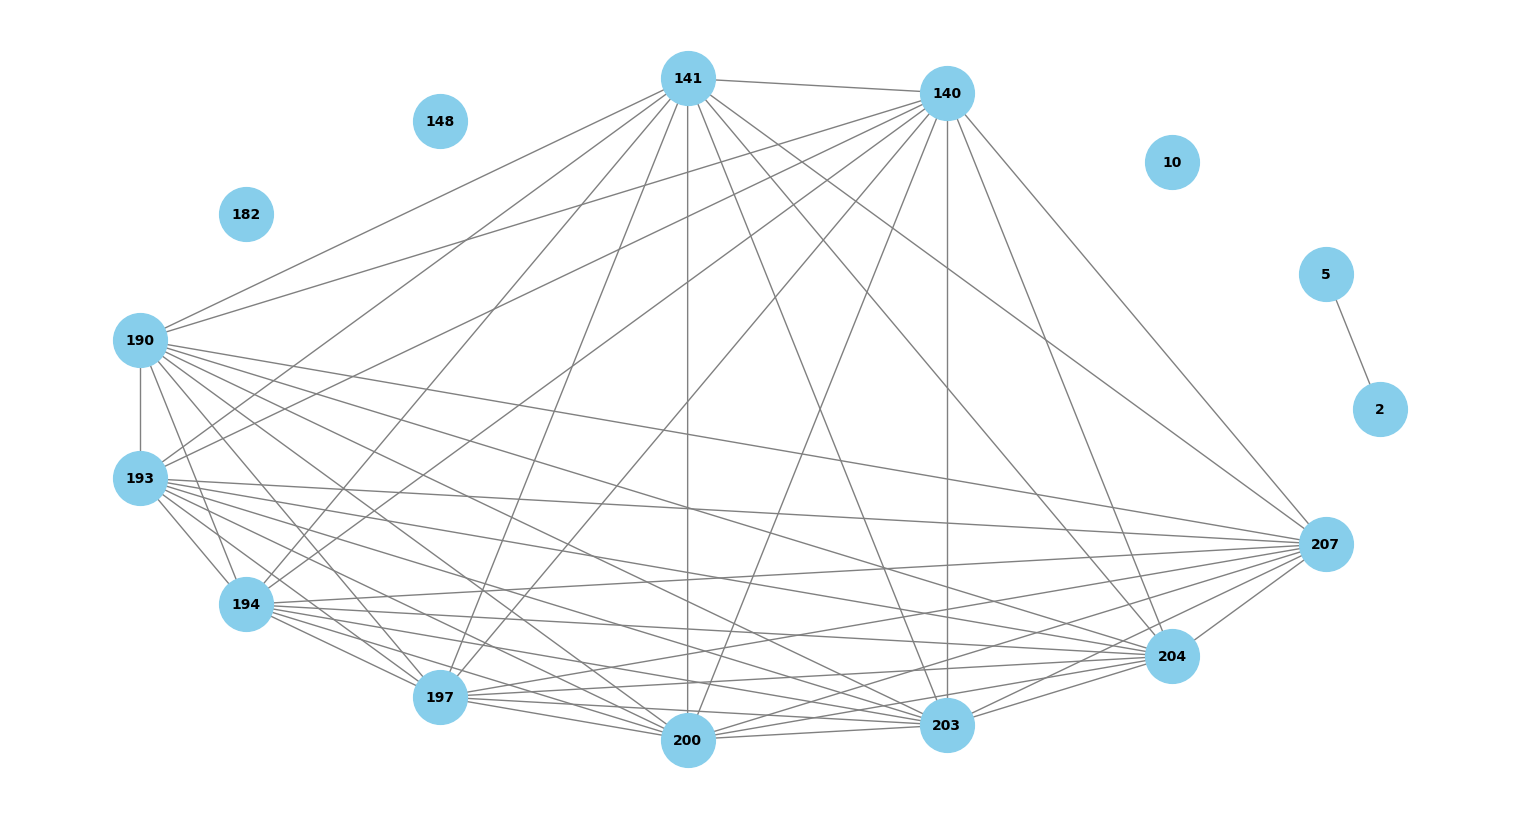

In [18]:
for_representation_df = intermediate_df.iloc[:15]
H = nx.Graph()
H.add_nodes_from(for_representation_df["track_id"])
pos = nx.circular_layout(H)

for i, row1 in tqdm(for_representation_df.iterrows()):
    for j, row2 in for_representation_df.iterrows():
        if row1["track_id"] != row2["track_id"] and row1["genre_top"] == row2["genre_top"]:
            H.add_edge(row1["track_id"], row2["track_id"])

print(H.edges())

plt.figure(figsize=(15, 8))
nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)

In [25]:
%pip install prettytable

  Using cached prettytable-3.10.0-py3-none-any.whl (28 kB)
Note: you may need to restart the kernel to use updated packages.


In [26]:
from prettytable import PrettyTable

In [36]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, out_channels)
        self.conv2 = SAGEConv(out_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x


model = GraphSAGE(in_channels=100, out_channels=100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| conv1.lin_l.weight |   10000    |
|  conv1.lin_l.bias  |    100     |
| conv1.lin_r.weight |   10000    |
| conv2.lin_l.weight |   10000    |
|  conv2.lin_l.bias  |    100     |
| conv2.lin_r.weight |   10000    |
+--------------------+------------+
Total Trainable Params: 40200


40200

In [11]:
# losses = []
# for epoch in range(50):
#     model.train()
#     epoch_loss = 0
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     epoch_loss /= len(data_loader)
#     losses.append(epoch_loss)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# plt.plot(range(1, len(losses)+1), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Graph SAGE Train Loss (vs) Epochs')
# plt.legend()
# plt.grid(True)
# plt.savefig('GraphSAGE_loss_plot.png')
# plt.show()

# model.eval()
# with torch.no_grad():
#     sage_embeddings = model(data).detach().numpy()

# np.save("mfcc_sage_embeddings_fma_5s.npy", sage_embeddings)
# print(sage_embeddings.shape)

In [37]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


model = GCN(in_channels=100, out_channels=100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |    100     |
| conv1.lin.weight |   10000    |
|    conv2.bias    |    100     |
| conv2.lin.weight |   10000    |
+------------------+------------+
Total Trainable Params: 20200


20200

In [12]:
# losses = []
# for epoch in range(50):
#     model.train()
#     epoch_loss = 0
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     epoch_loss /= len(data_loader)
#     losses.append(epoch_loss)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# plt.plot(range(1, len(losses)+1), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('GCN Train Loss (vs) Epochs')
# plt.legend()
# plt.grid(True)
# plt.savefig('GCN_loss_plot.png')
# plt.show()

# model.eval()
# with torch.no_grad():
#     gcn_embeddings = model(data).detach().numpy()

# np.save("mfcc_gcn_embeddings_fma_5s.npy", gcn_embeddings)
# print(gcn_embeddings.shape)

In [ ]:
class GraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, out_channels, heads=4, concat=True)
        self.conv2 = TransformerConv(
            out_channels * 4, out_channels, heads=4, concat=False
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


model = GraphTransformer(in_channels=100, out_channels=100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

In [13]:
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# model.eval()
# with torch.no_grad():
#     transformer_embeddings = model(data).detach().numpy()

# np.save("mfcc_gt_embeddings_fma_5s.npy", transformer_embeddings)
# print(transformer_embeddings.shape)

In [38]:
from torch.utils.data import DataLoader, TensorDataset

class SimpleMLP(nn.Module):
    def __init__(self, n_in, n_classes=n_genres):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, n_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x


<class 'torch.Tensor'> torch.Size([6395, 100]) <class 'torch.Tensor'> torch.Size([1599, 100]) torch.Size([6395]) torch.Size([1599])
+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   12800    |
|  fc1.bias  |    128     |
| fc2.weight |    4096    |
|  fc2.bias  |     32     |
| fc3.weight |    256     |
|  fc3.bias  |     8      |
+------------+------------+
Total Trainable Params: 17320


17320

<class 'torch.Tensor'> torch.Size([6395, 100]) <class 'torch.Tensor'> torch.Size([1599, 100]) torch.Size([6395]) torch.Size([1599])
Epoch 1, Loss: 1.9948576021194457
Epoch 11, Loss: 1.817401993870735


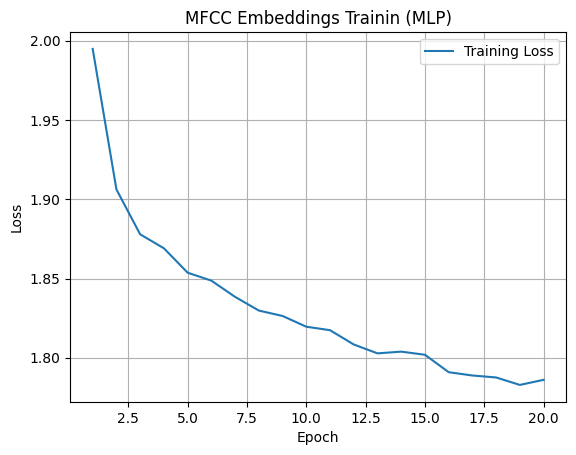

Accuracy: 42.77673545966229%
{'Electronic': ['Electronic', 'International', 'Electronic', 'Electronic', 'Instrumental', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Electronic'], 'Experimental': ['Experimental', 'Electronic', 'Pop', 'International', 'Pop', 'International', 'Hip-Hop', 'International', 'Pop', 'Experimental'], 'Folk': ['International', 'Rock', 'International', 'Hip-Hop', 'International', 'International', 'International', 'Folk', 'International', 'Hip-Hop'], 'Hip-Hop': ['Hip-Hop', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Experimental', 'Hip-Hop', 'Pop', 'International', 'Hip-Hop'], 'Instrumental': ['Experimental', 'Pop', 'Electronic', 'Folk', 'Instrumental', 'Experimental', 'Rock', 'Instrumental', 'Instrumental', 'Rock'], 'International': ['Instrumental', 'Pop', 'Hip-Hop', 'Rock', 'International', 'Pop', 'International', 'Hip-Hop', 'Pop', 'International'], 'Pop': ['Folk', 'International', 'Folk', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk'],

In [20]:
emb_scaled = StandardScaler().fit_transform(mfcc_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)


print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for mfcc_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(mfcc_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MFCC Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('mfcc_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for mfcc_batch, labels_batch in test_loader:
        outputs = model(mfcc_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")

In [32]:
mfcc_embeddings_recommendations = {}

for k, v in songs_for_inference.items():

    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]

        if genre not in mfcc_embeddings_recommendations:
            mfcc_embeddings_recommendations[genre] = []

        dist_mfcc = np.sqrt(np.sum((mfcc_embeddings - mfcc_embeddings[random_id]) ** 2, axis=1))
        idx = np.argsort(dist_mfcc)

        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        mfcc_embeddings_recommendations[genre].extend((random_id, recommendations))

print(mfcc_embeddings_recommendations)

for k, v in mfcc_embeddings_recommendations.items():
    print(k, v)

{'Electronic': [4157, ['Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Experimental'], 4703, ['Hip-Hop', 'Electronic', 'Hip-Hop', 'International', 'Pop', 'Electronic', 'Hip-Hop', 'Electronic', 'Folk', 'Folk'], 3832, ['Electronic', 'Hip-Hop', 'Electronic', 'International', 'Hip-Hop', 'Electronic', 'Electronic', 'Experimental', 'Hip-Hop', 'Electronic'], 3224, ['Electronic', 'Experimental', 'Electronic', 'Electronic', 'International', 'Hip-Hop', 'Electronic', 'Experimental', 'Pop', 'Electronic'], 2366, ['Hip-Hop', 'Pop', 'Hip-Hop', 'Electronic', 'International', 'Experimental', 'Hip-Hop', 'International', 'Electronic', 'Hip-Hop'], 7374, ['Folk', 'Pop', 'Rock', 'Folk', 'International', 'International', 'Folk', 'Folk', 'Experimental', 'Folk'], 2724, ['Pop', 'Experimental', 'Experimental', 'Pop', 'Experimental', 'Experimental', 'International', 'Instrumental', 'Folk', 'Folk'], 6174, ['Rock', 'International', 'Rock', 'Hip-Hop', 'Pop'

In [39]:
emb_scaled = StandardScaler().fit_transform(sage_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)

print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

train_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for emb_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(emb_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRAPHSAGE Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('sage_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for emb_batch, labels_batch in test_loader:
        outputs = model(emb_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")


<class 'torch.Tensor'> torch.Size([6395, 100]) <class 'torch.Tensor'> torch.Size([1599, 100]) torch.Size([6395]) torch.Size([1599])
+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   12800    |
|  fc1.bias  |    128     |
| fc2.weight |    4096    |
|  fc2.bias  |     32     |
| fc3.weight |    256     |
|  fc3.bias  |     8      |
+------------+------------+
Total Trainable Params: 17320


17320

In [33]:
sage_embeddings_recommendations = {}

for k, v in songs_for_inference.items():
    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]

        if genre not in sage_embeddings_recommendations:
            sage_embeddings_recommendations[genre] = []

        dist_emb = np.sqrt(np.sum((sage_embeddings - sage_embeddings[random_id]) ** 2, axis=1))
        idx = np.argsort(dist_emb)

        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        sage_embeddings_recommendations[genre].extend((random_id, recommendations))

print(sage_embeddings_recommendations)

for k, v in sage_embeddings_recommendations.items():
    print(k, v)

{'Electronic': [4157, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop'], 4703, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 3832, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 3224, ['Hip-Hop', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic'], 2366, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic'], 7374, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 2724, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Electronic', 'Electr

<class 'torch.Tensor'> torch.Size([6395, 100]) <class 'torch.Tensor'> torch.Size([1599, 100]) torch.Size([6395]) torch.Size([1599])
Epoch 1, Loss: 1.390933938920498
Epoch 11, Loss: 1.2762454655766486


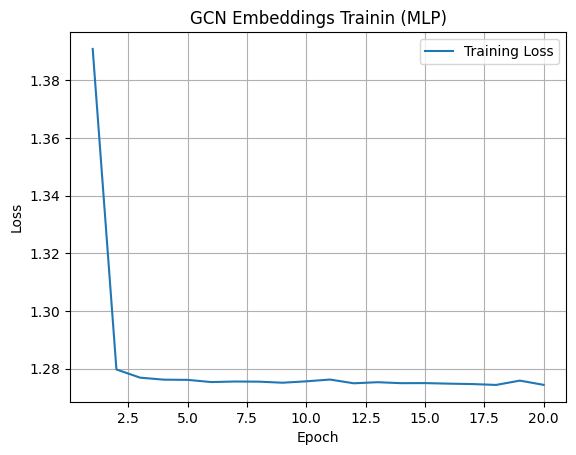

Accuracy: 100.0%
{'Electronic': ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 'Experimental': ['Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental'], 'Folk': ['Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk'], 'Hip-Hop': ['Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop'], 'Instrumental': ['Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental'], 'International': ['International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International'], 'Pop': ['Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop

In [22]:
emb_scaled = StandardScaler().fit_transform(gcn_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)

print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for emb_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(emb_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('gcn_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for emb_batch, labels_batch in test_loader:
        outputs = model(emb_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")



In [34]:
gcn_embeddings_recommendations = {}

for k, v in songs_for_inference.items():
    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]

        if genre not in gcn_embeddings_recommendations:
            gcn_embeddings_recommendations[genre] = []

        dist_emb = np.sqrt(np.sum((gcn_embeddings - gcn_embeddings[random_id]) ** 2, axis=1))
        idx = np.argsort(dist_emb)

        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        gcn_embeddings_recommendations[genre].extend((random_id, recommendations))

print(gcn_embeddings_recommendations)

for k, v in gcn_embeddings_recommendations.items():
    print(k, v)

{'Electronic': [4157, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 4703, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 3832, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 3224, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 2366, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 7374, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 2724, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Elec

In [35]:
all_recommendations = {
    'mfcc_rec': mfcc_embeddings_recommendations,
    'sage_rec': sage_embeddings_recommendations,
    'gcn_rec': gcn_embeddings_recommendations,
}

In [53]:
master_dict = {}
for k, v in all_recommendations.items():
    master_dict[k] = {}
    for genre, rec in v.items():
        for_inf, recommendations = [], []
        for i, r in enumerate(rec):
            if i % 2 == 0:
                for_inf.append(r)
            else:
                recommendations.append(r)
        master_dict[k][genre] = recommendations

print(master_dict.keys())

dict_keys(['mfcc_rec', 'sage_rec', 'gcn_rec'])


In [84]:
accuracy_scores = {}
for k, v in master_dict.items():
    accuracy_scores[k] = {}
    for i, j in v.items():
        accuracy_scores[k][i] = []
        for n in j:
            count_of_genres = n.count(i)
            accuracy_scores[k][i].append(count_of_genres / 10)

print(len(accuracy_scores))

3


In [96]:
final_dict = {}

for emb, rec in accuracy_scores.items():
    final_dict[emb] = {}
    for genre, acc in rec.items():
        final_dict[emb][genre] = round(np.mean(acc) * 100, 3)


In [97]:
final_dict

{'mfcc_rec': {'Electronic': 27.7,
  'Experimental': 22.6,
  'Folk': 24.8,
  'Hip-Hop': 33.4,
  'Instrumental': 26.0,
  'International': 34.6,
  'Pop': 16.1,
  'Rock': 50.0},
 'sage_rec': {'Electronic': 82.2,
  'Experimental': 96.6,
  'Folk': 99.2,
  'Hip-Hop': 76.4,
  'Instrumental': 100.0,
  'International': 97.7,
  'Pop': 99.2,
  'Rock': 100.0},
 'gcn_rec': {'Electronic': 100.0,
  'Experimental': 100.0,
  'Folk': 100.0,
  'Hip-Hop': 100.0,
  'Instrumental': 100.0,
  'International': 100.0,
  'Pop': 100.0,
  'Rock': 100.0}}

In [98]:
final_df = pd.DataFrame(final_dict)
print(final_df)
final_df.to_csv('recommendations.csv', index=True)

               mfcc_rec  sage_rec  gcn_rec
Electronic         27.7      82.2    100.0
Experimental       22.6      96.6    100.0
Folk               24.8      99.2    100.0
Hip-Hop            33.4      76.4    100.0
Instrumental       26.0     100.0    100.0
International      34.6      97.7    100.0
Pop                16.1      99.2    100.0
Rock               50.0     100.0    100.0


In [100]:
print(final_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
)) 

\begin{tabular}{lrrr}
\toprule
 & mfcc_rec & sage_rec & gcn_rec \\
\midrule
Electronic & 27.70 & 82.20 & 100.00 \\
Experimental & 22.60 & 96.60 & 100.00 \\
Folk & 24.80 & 99.20 & 100.00 \\
Hip-Hop & 33.40 & 76.40 & 100.00 \\
Instrumental & 26.00 & 100.00 & 100.00 \\
International & 34.60 & 97.70 & 100.00 \\
Pop & 16.10 & 99.20 & 100.00 \\
Rock & 50.00 & 100.00 & 100.00 \\
\bottomrule
\end{tabular}



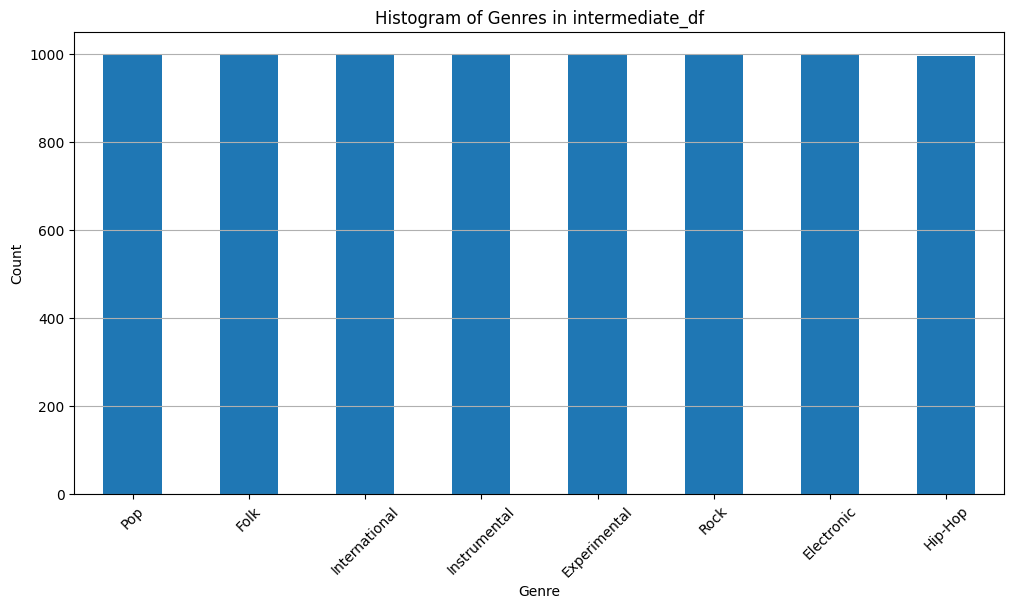

In [24]:
plt.figure(figsize=(12, 6))
intermediate_df['genre_top'].value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Histogram of Genres in intermediate_df')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('genre_histogram.png')

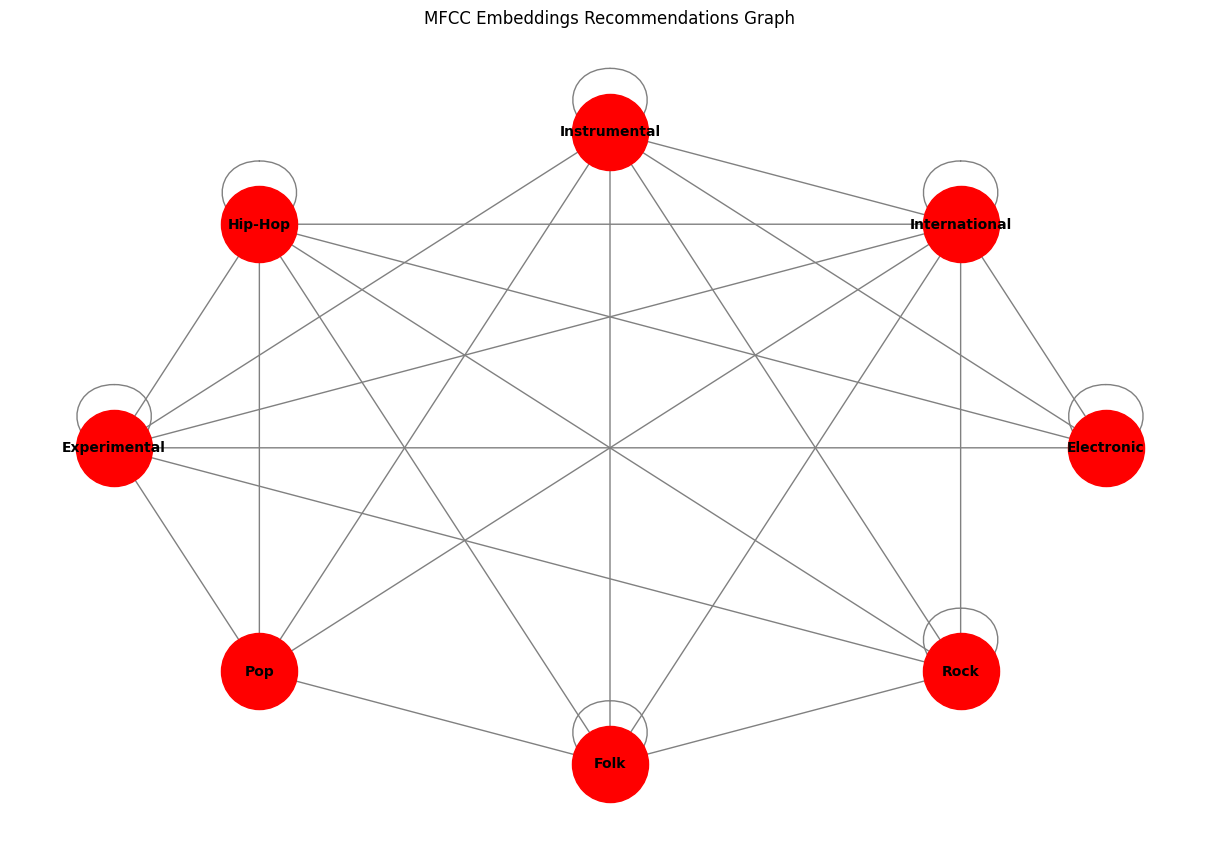

In [26]:
H1 = nx.Graph()

for genre, recommendations in mfcc_embeddings_recommendations.items():
    for r in recommendations:
        H1.add_edge(genre, r)

plt.figure(figsize=(12, 8))
pos = nx.circular_layout(H1)
nx.draw(H1, pos, with_labels=True, node_size=3000, node_color="red", font_size=10, font_weight="bold", edge_color="gray", arrows=True)
plt.title('MFCC Embeddings Recommendations Graph')
plt.show()

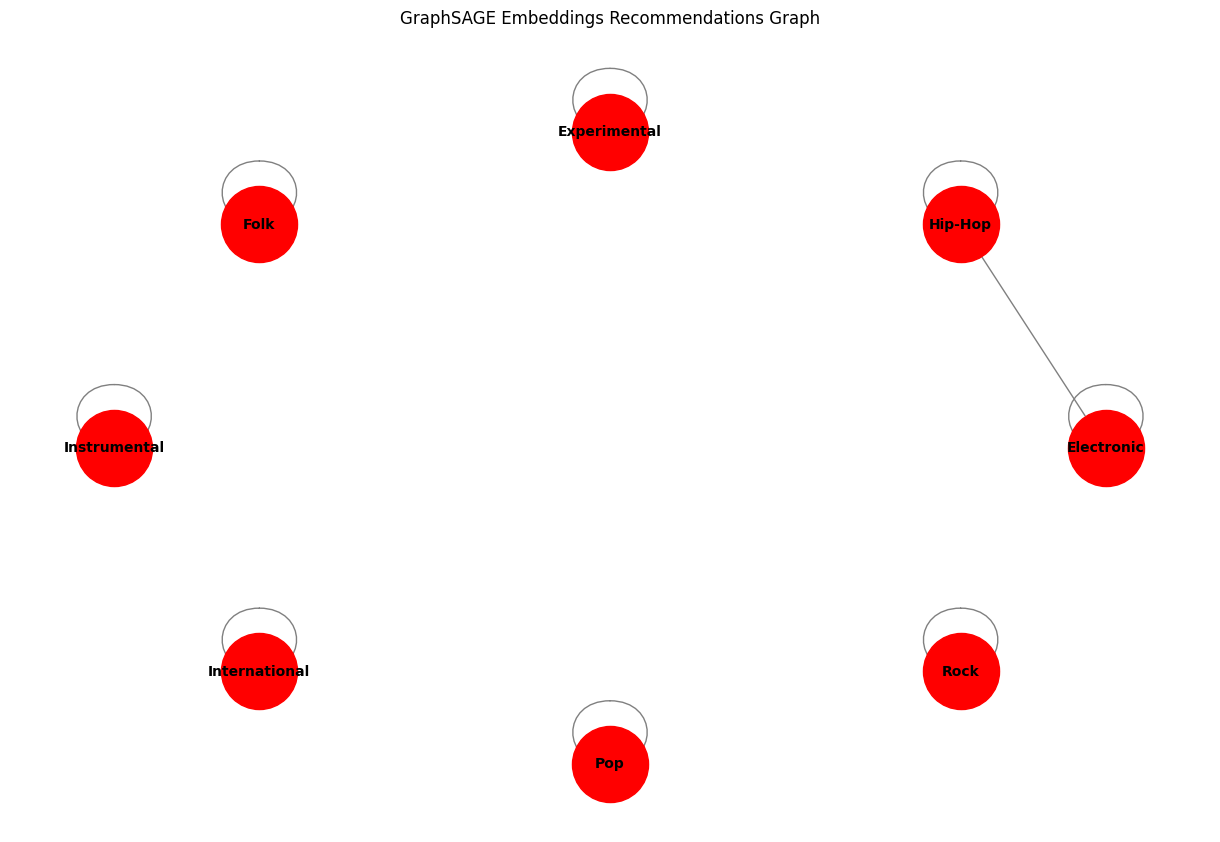

In [27]:
H2 = nx.Graph()

for genre, recommendations in sage_embeddings_recommendations.items():
    for r in recommendations:
        H2.add_edge(genre, r)

plt.figure(figsize=(12, 8))
pos = nx.circular_layout(H2)
nx.draw(H2, pos, with_labels=True, node_size=3000, node_color="red", font_size=10, font_weight="bold", edge_color="gray", arrows=True)
plt.title('GraphSAGE Embeddings Recommendations Graph')
plt.show()

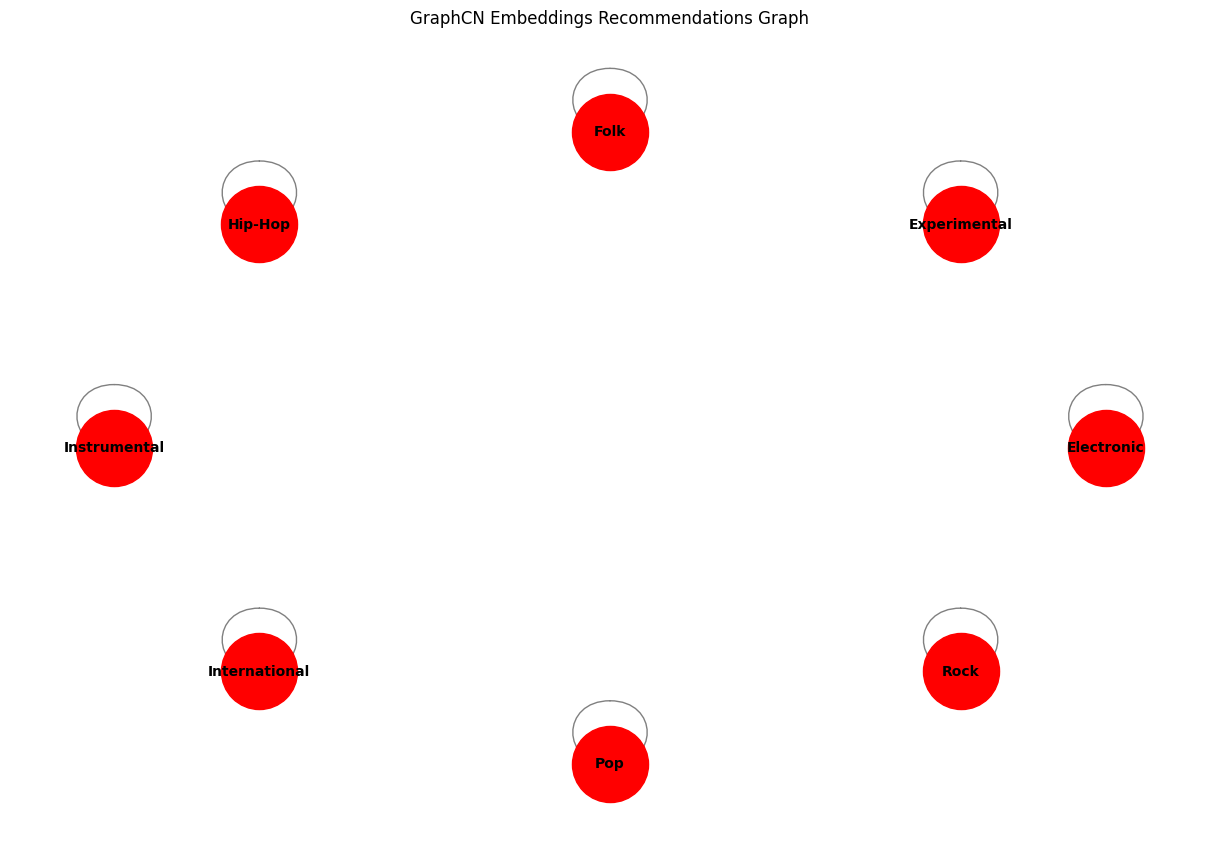

In [28]:
H3 = nx.Graph()

for genre, recommendations in gcn_embeddings_recommendations.items():
    for r in recommendations:
        H3.add_edge(genre, r)

plt.figure(figsize=(12, 8))
pos = nx.circular_layout(H3)
nx.draw(H3, pos, with_labels=True, node_size=3000, node_color="red", font_size=10, font_weight="bold", edge_color="gray", arrows=True)
plt.title('GraphCN Embeddings Recommendations Graph')
plt.show()

In [13]:
def calculate_cosine_similarity(embeddings, random_id):
    embeddings = np.array(embeddings)
    reference_embedding = embeddings[random_id]
    dot_product = np.dot(embeddings, reference_embedding)
    norms = np.linalg.norm(embeddings, axis=1)
    reference_norm = np.linalg.norm(reference_embedding)
    cosine_similarity = dot_product / (norms * reference_norm)
    return cosine_similarity


def calculate_euclidean_distance(embeddings, random_id):
    embeddings = np.array(embeddings)
    distances = np.sqrt(np.sum((embeddings - embeddings[random_id]) ** 2, axis=1))
    return distances


def calculate_manhattan_distance(embeddings, random_id):
    reference_embedding = embeddings[random_id]
    manhattan_distance = np.sum(np.abs(embeddings - reference_embedding), axis=1)
    return manhattan_distance


def calculate_chebyshev_distance(embeddings, random_id):
    reference_embedding = embeddings[random_id]
    chebyshev_distance = np.max(np.abs(embeddings - reference_embedding), axis=1)
    return chebyshev_distance


def calculate_minkowski_distance(embeddings, random_id, p):
    reference_embedding = embeddings[random_id]
    minkowski_distance = np.sum(
        np.abs(embeddings - reference_embedding) ** p, axis=1
    ) ** (1 / p)
    return minkowski_distance


def calculate_hamming_distance(embeddings, random_id):
    reference_embedding = embeddings[random_id]
    hamming_distance = np.sum(embeddings != reference_embedding, axis=1)
    return hamming_distance


def calculate_jaccard_distance(embeddings, random_id):
    reference_embedding = embeddings[random_id]
    intersection = np.sum(np.minimum(embeddings, reference_embedding), axis=1)
    union = np.sum(np.maximum(embeddings, reference_embedding), axis=1)
    jaccard_distance = np.abs(1 - intersection / union)
    return jaccard_distance